In [36]:
#load image for Calibration
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import random

%matplotlib inline

images_unCal = np.array([plt.imread(i) for i in glob.glob('./CarND-Advanced-Lane-Lines/camera_cal/*.jpg')])
image_size = (images_unCal[0].shape[1], images_unCal[0].shape[0])

In [37]:
#function of calibrate cameras
def GetCalibrateParameters(imgs, imgSize):
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((9*6,3), np.float32)#object 3D coordinates
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    for i,oriImg in enumerate(imgs):
        grayImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(grayImg, (9,6), None)
        #print(ret)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            #cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            #plt.imshow(img)
    
    #mtx = 3d -> 2d matrix
    #dist = distortion coffecient
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    return mtx, dist

In [40]:
calMatrix, distCoff = GetCalibrateParameters(images_unCal, image_size)

#undistort image
index = random.randint(0, len(images_unCal))
print(index)
image_cal = cv2.undistort(images_unCal[index], calMatrix, distCoff, None, calMatrix)

5


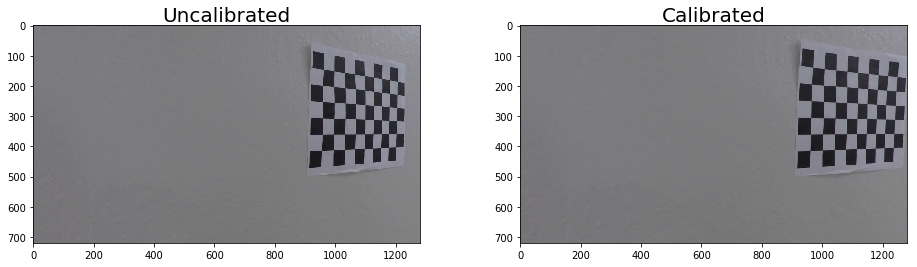

In [41]:
#test on chest image
f,(ax1,ax2) = plt.subplots(1,2,figsize = (16,4))
ax1.imshow(images_unCal[index])
ax1.set_title('Uncalibrated',fontsize=20)
ax2.imshow(image_cal)
ax2.set_title('Calibrated',fontsize=20)

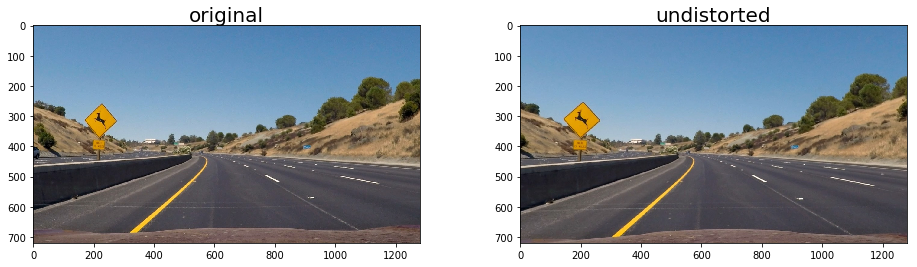

In [99]:
#test on traffic images
images_test = np.array([plt.imread(i) for i in glob.glob('./CarND-Advanced-Lane-Lines/test_images/*.jpg')]) 

index = random.randint(0, len(images_test))

#image_ori = images_test[index]
image_ori = images_test[3]
image_traffic = cv2.undistort(image_ori,calMatrix, distCoff, None, calMatrix)
f,(ax1,ax2) = plt.subplots(1,2,figsize = (16,4))
ax1.imshow(image_ori)
ax1.set_title('original',fontsize=20)
ax2.imshow(image_traffic)
ax2.set_title('undistorted',fontsize=20)

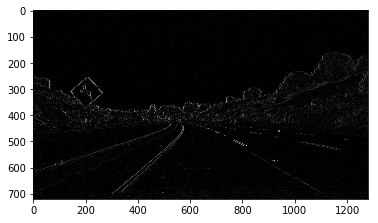

In [100]:
#Threshold image
def gradient_threshold(grayimg, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(grayimg, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(grayimg, cv2.CV_64F, 0, 1))
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return scaled_sobel,binary_output

#test
HLS = cv2.cvtColor(image_traffic, cv2.COLOR_RGB2HLS).astype(np.float)
L_channel = HLS[:,:,1]
S_channel = HLS[:,:,2]
soble_img,binary_img = gradient_threshold(L_channel, thresh_min = 125, thresh_max = 225)
plt.imshow(soble_img,cmap='gray')

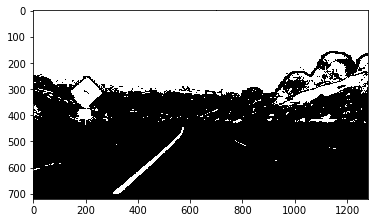

In [101]:
# color threshold
def color_threshold(s_channel, s_min=0, s_max= 255):
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > s_min) & (s_channel <= s_max)] = 1
    
    return binary_output

#test
hls_binary = color_threshold(S_channel, s_min=90, s_max=255)
plt.imshow(hls_binary,cmap='gray')

In [118]:
def getlaneInfo(img, gradientThreshold=(0, 255), colorThreshold=(0,255)):
    mask_vertices = np.array([[[120, 720], [400, 466], [852, 464], [1234, 720]]])
    mask = np.uint8(np.zeros_like(img[:,:,0]))
    maskimg = cv2.fillPoly(mask, mask_vertices, (1))
    
    imgcp = np.copy(img)
    HLSimg = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = HLSimg[:,:,1]
    s_channel = HLSimg[:,:,2]
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
 
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= gradientThreshold[0]) & (scaled_sobel <= gradientThreshold[1])] = 1

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= colorThreshold[0]) & (s_channel <= colorThreshold[1])] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    combined_binary = cv2.bitwise_and(combined_binary, mask)
    ##measure 2
  
    c_channel = np.max(img,axis=2)-np.min(img,axis=2)
    _,c_binary = cv2.threshold(c_channel,90,255,cv2.THRESH_BINARY)
    
    _, gray_binary = cv2.threshold(gray,200,217,cv2.THRESH_BINARY)
    
    combined_binary_masked = cv2.bitwise_and(cv2.bitwise_or(c_binary,gray_binary), mask)
    combined_binary_masked2 = cv2.bitwise_or(combined_binary, combined_binary_masked)
    return combined_binary_masked

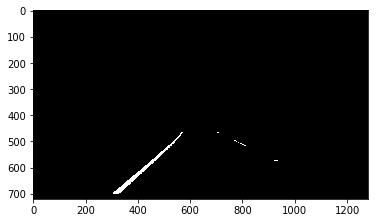

In [119]:
img_binary = getlaneInfo(image_traffic, gradientThreshold=(50, 250), colorThreshold=(70,255))
plt.imshow(img_binary,cmap='gray')

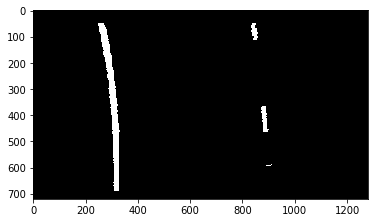

In [134]:
#perspective transform
def perspective_transform(img_binary,src,dst):
    img_size = img_binary.shape[::-1]
    M = cv2.getPerspectiveTransform(src, dst)
    warped_img = cv2.warpPerspective(img_binary, M, img_binary.shape[::-1], flags=cv2.INTER_LINEAR)
    return warped_img

src = np.float32([[258, 679], [446, 549], [837, 549], [1045, 679]]) # perspective transform source
dst = np.float32([[258, 679], [258, 549], [837, 549], [837, 679]]) # perspective transform destion
#src = np.float32([[306, 688], [412, 598], [960, 598], [1124, 688]])
#dst = np.float32([[306, 688], [306, 598], [960, 598], [960, 688]])

img_transform = perspective_transform(img_binary, src, dst)
plt.imshow(img_transform,cmap='gray')

In [121]:
def find_lane(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return [leftx, lefty],[rightx, righty],[left_fit, right_fit]

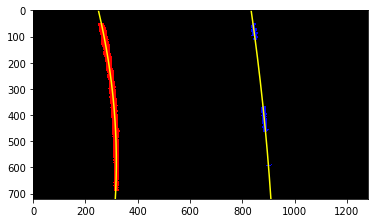

In [122]:
left_lane, right_lane, [left_fit, right_fit] = find_lane(img_transform)

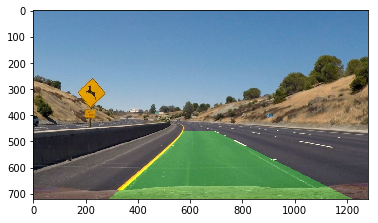

In [123]:
#draw lines on images
def drawlines(img, lfit, rfit, src, dst):
    #get fit points
    ploty = np.linspace(0, 700)
    lfitx = lfit[0]*ploty**2 + lfit[1]*ploty + lfit[2]
    rfitx = rfit[0]*ploty**2 + rfit[1]*ploty + rfit[2]
    
    #reverse perspective transform for curve image
    matrix = cv2.getPerspectiveTransform(dst,src)
    
    pts_left = np.array([np.transpose(np.vstack([lfitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rfitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    color_warp = np.zeros_like(img).astype(np.uint8)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, matrix, (img.shape[1], img.shape[0]))
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

mark_img = drawlines(images_test[3], left_fit, right_fit, src, dst)
plt.imshow(mark_img)


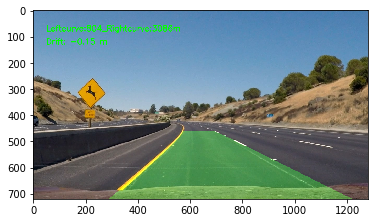

In [135]:
#function2: measure curvature
def measure_curvature(img, llane, rlane):
    leftx = llane[0]
    lefty = llane[1] 
    rightx = rlane[0]
    righty = rlane[1]
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*720*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*720*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curve_mean = (left_curverad + right_curverad)/2
    lfit = np.polyfit(lefty, leftx, 2)
    rfit = np.polyfit(righty, rightx, 2)
    
    left_lane_real  = lfit[0]*720**2 + lfit[1]*720 + lfit[2]
    right_lane_real = rfit[0]*720**2 + rfit[1]*720 + rfit[2]
    
    #deviation of car comparing to road
    deviation = ((right_lane_real + left_lane_real)/2. - 1280/2.)*xm_per_pix
    
    img_cp = np.copy(img)
    cv2.putText(img_cp, "Leftcurve:{0}_Rightcurve:{1}m".format(int(left_curverad), int(right_curverad)), (50,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    cv2.putText(img_cp, "Drift: {0:.2f} m".format(deviation), (50,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    return img_cp

img_final = measure_curvature(mark_img,left_lane, right_lane)
plt.imshow(img_final)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:41<00:00,  4.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 48s, sys: 47.9 s, total: 5min 35s
Wall time: 4min 42s


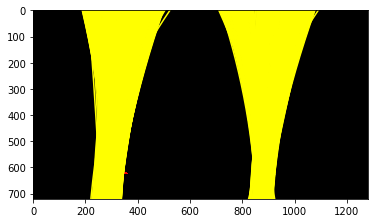

In [136]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def lane_detection(oriImg, dist_mtx = calMatrix, dist_param = distCoff, gThreshold =(50, 250), cThreshold = (70,255),
                  src=src, dst=dst):
    img_video = np.copy(oriImg)
    image_undist_video = cv2.undistort(img_video,dist_mtx, dist_param, None, calMatrix)
    img_binary_video = getlaneInfo(image_undist_video, gradientThreshold=gThreshold, colorThreshold=cThreshold)
    img_warped_video = perspective_transform(img_binary_video,src,dst)
    left_lane_video, right_lane_video, [left_fit_video, right_fit_video] = find_lane(img_warped_video)
    img_polyfit = drawlines(image_undist_video, left_fit_video, right_fit_video, src, dst)
    img_result = measure_curvature(img_polyfit, left_lane_video, right_lane_video)
    
    return img_result
    
project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("CarND-Advanced-Lane-Lines/project_video.mp4")
lane_clip = clip1.fl_image(lane_detection)
%time lane_clip.write_videofile(project_video_output, audio=False)